In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score  
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import xarray as xr
import numpy as np
import joblib
#from imblearn.ensemble import BalancedRandomForestClassifier


import helper
from helper import plot_confusion_matrix, print_classification_report

# from dask.distributed import Client, progress
# client = Client(processes=False, threads_per_worker=1,
#                 n_workers=40, memory_limit='2.5GB', dashboard_address=':8787')
# client

from autogluon.tabular import TabularDataset, TabularPredictor

/home/jomueller/micromamba/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = xr.open_dataset('../../data/training_flat.nc')
data

<xarray.Dataset> Size: 2GB
Dimensions:  (z: 20282535)
Coordinates:
  * z        (z) int64 162MB 0 1 2 3 4 ... 20282531 20282532 20282533 20282534
Data variables:
    y        (z) float64 162MB ...
    X1       (z) float32 81MB ...
    X2       (z) float32 81MB ...
    X3       (z) float32 81MB ...
    X4       (z) float32 81MB ...
    X5       (z) float32 81MB ...
    X6       (z) float64 162MB ...
    X7       (z) float64 162MB ...
    X8       (z) float64 162MB ...
    group    (z) int64 162MB ...
    sample   (z) datetime64[ns] 162MB ...

In [4]:
samples = np.unique(data.sample)

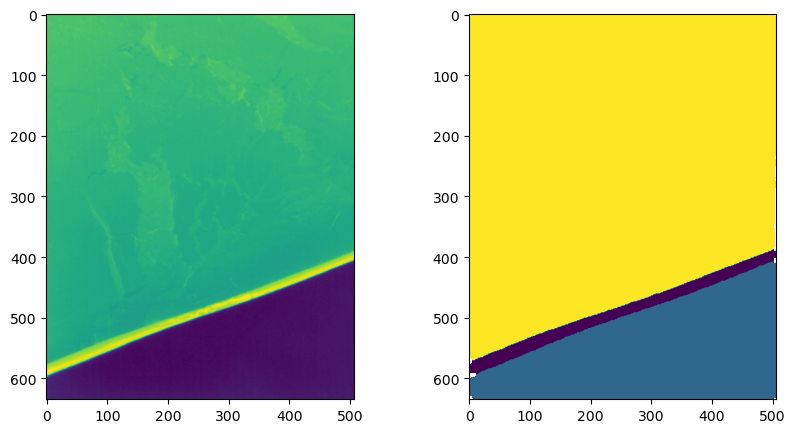

In [5]:
mask = data.sample == samples[0]
test= data.isel(z=mask)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test.X1.values.reshape(635, 507))
ax[1].imshow(test.y.values.reshape(635, 507))
# okay, the images can be reproduced from the data, so we can use the data to train a model

Classes: ['1.0 (4.44%)', '2.0 (18.95%)', '4.0 (40.31%)', 'nan (36.30%)']
Names: Open-Water (1), Thin Ice (2), Snow-Covered (3)
Total: 20282535
After Filtering NaNs
Classes: ['1.0 (7.05%)', '2.0 (30.12%)', '4.0 (62.83%)']
Names: Open-Water (1), Thin Ice (2), Snow-Covered (3)
Total: 12760624


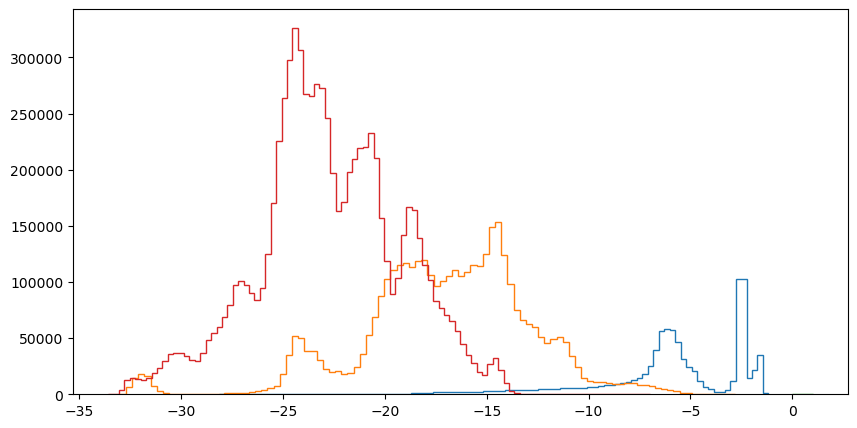

In [6]:
unique, count = np.unique(data['y'], return_counts=True)

print('Classes:', [f'{u} ({c / count.sum() * 100:.2f}%)' for u, c in zip(unique, count)])
print('Names:', 'Open-Water (1), Thin Ice (2), Snow-Covered (3)')
print('Total:', count.sum())
#

#X = data[['X1', 'X7', 'X8']].to_array().values.T
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].to_array().values.T
y = data['y'].values

mask = np.isnan(X).any(axis=1) | np.isnan(y) 
X = X[~mask]
y = y[~mask]

unique, count = np.unique(y, return_counts=True)

print('After Filtering NaNs')
print('Classes:', [f'{u} ({c / count.sum() * 100:.2f}%)' for u, c in zip(unique, count)])
print('Names:', 'Open-Water (1), Thin Ice (2), Snow-Covered (3)')
print('Total:', count.sum())
#

# plot the distribution of the classes

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.hist(X[y==1, 0], bins=100, label='Open-Water', histtype='step')
plt.hist(X[y==2, 0], bins=100, label='Thin Ice', histtype='step')
plt.hist(X[y==3, 0], bins=100, label='Snow-Covered', histtype='step')
plt.hist(X[y==4, 0], bins=100, label='Dark Nilas', histtype='step')
plt.show()

RESAMPLING
Classes: ['1.0 (33.33%)', '2.0 (33.33%)', '4.0 (33.33%)']
Names: Open-Water (1), Thin Ice (2), Snow-Covered (3)
Total: 2700306


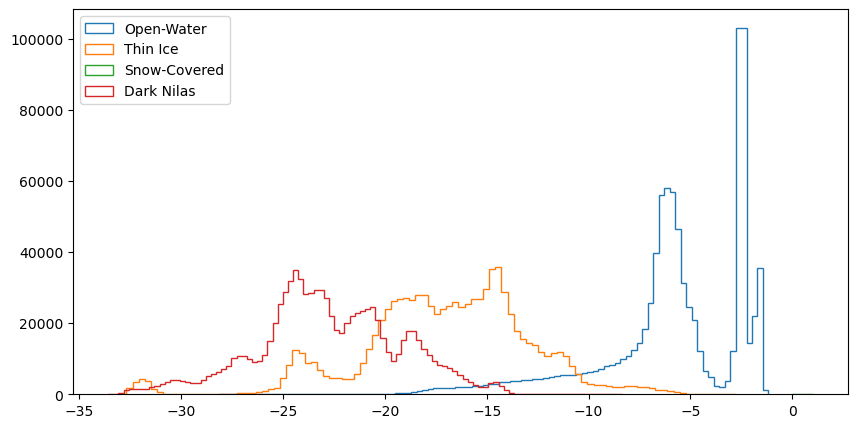

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X, y)

unique, count = np.unique(y_resampled, return_counts=True)

print('RESAMPLING')

print('Classes:', [f'{u} ({c / count.sum() * 100:.2f}%)' for u, c in zip(unique, count)])
print('Names:', 'Open-Water (1), Thin Ice (2), Snow-Covered (3)')
print('Total:', count.sum())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.hist(X_resampled[y_resampled==1, 0], bins=100, label='Open-Water', histtype='step')
plt.hist(X_resampled[y_resampled==2, 0], bins=100, label='Thin Ice', histtype='step')
plt.hist(X_resampled[y_resampled==3, 0], bins=100, label='Snow-Covered', histtype='step')
plt.hist(X_resampled[y_resampled==4, 0], bins=100, label='Dark Nilas', histtype='step')
plt.legend()
plt.show()

In [14]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd

train_data = TabularDataset(pd.DataFrame(X_resampled, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']))
train_data

train_data['label'] = y_resampled

predictor = TabularPredictor(label='label').fit(train_data, presets='medium_quality', time_limit=100)

No path specified. Models will be saved in: "AutogluonModels/ag-20240506_102601"
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to "AutogluonModels/ag-20240506_102601"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Debian 6.1.76-1 (2024-02-01)
CPU Count:          64
Memory Avail:       520.80 GB / 1007.74 GB (51.7%)
Disk Space Avail:   37109.52 GB / 155833.13 GB (23.8%)
Train Data Rows:    2700306
Train Data Columns: 8
Label Column:       label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == float, but few unique label-values observed and label-values can be converted to int).
	3 unique label values:  [1.0, 2.0, 4.0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during 

In [7]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

model = make_pipeline(
    RandomUnderSampler(random_state=0),
    RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=5)
)
cv_results = cross_validate(
    model, X, y, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True, verbose=100,
    n_jobs=5
)
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  9.2min
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.6min remaining: 14.3min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  9.9min remaining:  6.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 11.1min finished
Balanced accuracy mean +/- std. dev.: 0.827 +/- 0.006


[CV] START .....................................................................
[CV] END ..................., score=(train=0.880, test=0.822) total time= 5.3min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.883, test=0.826) total time= 5.3min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.881, test=0.837) total time= 5.6min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.883, test=0.820) total time= 5.7min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.882, test=0.830) total time= 5.3min


In [9]:
# make sure no NaNs are left

print('NaNs in X:', sum(sum(sum([np.isnan(X)]))))
print('NaNs in y:', sum(np.isnan(y)))

clf = RandomForestClassifier(n_estimators=50, 
                             max_depth=50, 
                             bootstrap=True,
                             n_jobs=48)

bclf = BalancedRandomForestClassifier(n_estimators=10, 
                                      random_state=0, 
                                      sampling_strategy='all', # 'not minority', 'not majority', 'all', 'majority', 'minority', 'not minority', 'auto'
                                      replacement=True,
                                      bootstrap=False,
                                        n_jobs=48)

NaNs in X: 0
NaNs in y: 0


In [24]:
#y_pred = cross_val_predict(clf, X_resampled, y_resampled, cv=5, verbose=100)
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=50, n_jobs=48)

In [13]:
#print('Accuracy:', accuracy_score(y_resampled, y_pred))

In [15]:
def print_classification_report(classification_report):
    """
    Print the classification report in a pretty way.
    
    Parameters:
        classification_report (dict): The classification report.
    """
    print(f"{'Label':<20} {'Precision':<20} {'Recall':<20} {'F1-score':<20}")
    for label, metrics in classification_report.items():
        if label == 'accuracy': 
            print('accuracy_score:' , metrics)
            print('\n')

        else:
            print(f"{label:<20} {metrics['precision']:<20} {metrics['recall']:<20} {metrics['f1-score']:<20}")
            print('-'*80)

    # plot the confusion matrix in a pretty way

def plot_confusion_matrix(confusion_matrix):

    plt.figure(figsize=(6, 4))
    plt.imshow(confusion_matrix, cmap='Reds', )
    plt.title('Confusion matrix')
    plt.colorbar(label='Total number of samples')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1, 2], ['Open Water', 'Thin Ice', 'Snow-covered Sea Ice'], rotation=45)
    plt.yticks([0, 1, 2], ['Open Water', 'Thin Ice', 'Snow-covered Sea Ice'], rotation=45)

    # plot the percentage of the confusion matrix into the figure

    
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, f'{confusion_matrix[i, j]:.4f}',
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > .9 else "black")



In [21]:
cm = confusion_matrix(y_resampled, y_pred)
plot_confusion_matrix(cm)
print_classification_report(classification_report(y_resampled, y_pred, output_dict=True))

ValueError: Found input variables with inconsistent numbers of samples: [2700306, 12919914]

Label                Precision            Recall               F1-score            
1.0                  0.8684212049699269   0.9999933340888033   0.9295746719984137  
--------------------------------------------------------------------------------
2.0                  0.7370845700276114   0.8304916007429461   0.781005166905864   
--------------------------------------------------------------------------------
4.0                  0.9300250282050804   0.8577121336924836   0.8924060743722448  
--------------------------------------------------------------------------------
accuracy_score: 0.8595503636812746


macro avg            0.8451769344008729   0.8960656895080777   0.8676619710921741  
--------------------------------------------------------------------------------
weighted avg         0.8675723648687609   0.8595503636812746   0.8614775831320379  
--------------------------------------------------------------------------------


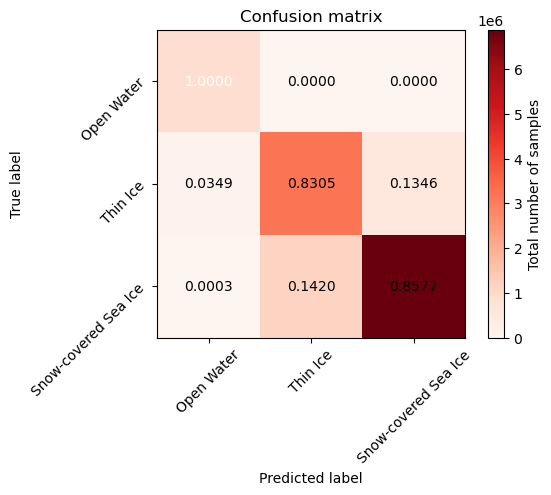

In [25]:
# now, let's predict on the full dataset and see how well our classifier performs

y_pred = clf.predict(X)

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm)
print_classification_report(classification_report(y, y_pred, output_dict=True))

In [27]:
clf.feature_importances_

array([0.24000905, 0.05122034, 0.04072413, 0.06540517, 0.04866343,
       0.07722238, 0.2958133 , 0.18094221])

In [14]:
data['y_pred'] = ('z',np.nan*np.zeros(data['y_corrected'].shape))
#data['y_pred'].values[~mask] = y_pred

for s in samples:
    mask = data['sample'] == s
    #X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].to_array().values[:,mask].T
    X = data[['X1', 'X7', 'X8']].to_array().values[:,mask].T
    y_pred = clf.predict(X)
    data['y_pred'].values[mask] = y_pred

    ## add a gaussian filter to the prediction


    ## plot the result

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5, 3))
    im =ax.imshow(data['y_pred'][mask].values.reshape(635, 507))
    im2 =ax2.imshow(data['y_corrected'][mask].values.reshape(635, 507))
    fig.colorbar(im, ax=ax)
    fig.colorbar(im2, ax=ax2)
    plt.savefig(f'plots/sample_{s}.png')
    plt.close()

    plt.show()

KeyboardInterrupt: 

In [29]:
test = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.nc')

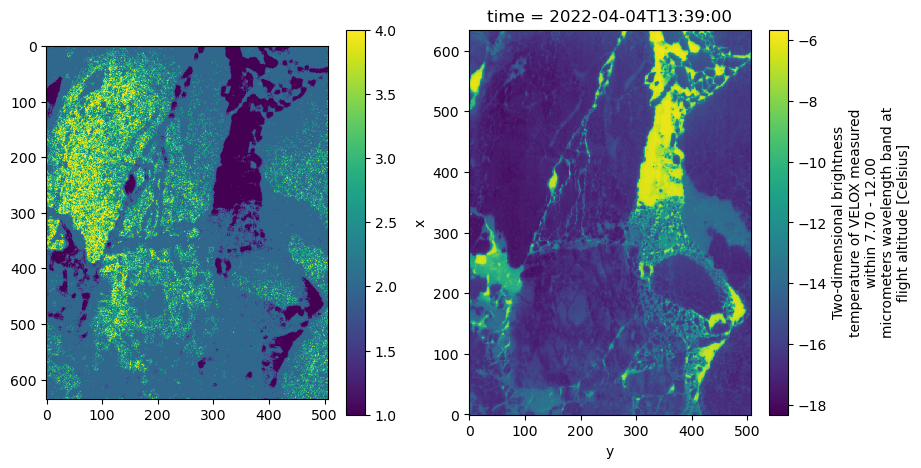

In [35]:
test_slice = test.sel(time='2022-04-04T13:39:00')
#test_slice = test.isel(time=-1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
test_slice.BT_2D.isel(band=0).plot(ax=ax[1], x='y')

X1 = test_slice.BT_2D.isel(band=0).values
X2 = test_slice.BT_2D.isel(band=1).values
X3 = test_slice.BT_2D.isel(band=2).values
X4 = test_slice.BT_2D.isel(band=3).values
X5 = test_slice.BT_2D.isel(band=4).values
X6 = test_slice.sur_rgh.values
X7 = test_slice.neighbor_mean.values
X8 = test_slice.neighbor_std.values

X = np.stack([X1, X7, X8], axis=-1).reshape(-1, 3)

y_pred = cv_results['estimator'][0].predict(X)

im = ax[0].imshow(y_pred.reshape(635, 507)[::-1, :])

## add a gaussian filter to the prediction


fig.colorbar(im, ax=ax[0])

Text(0, 0.5, 'Density')

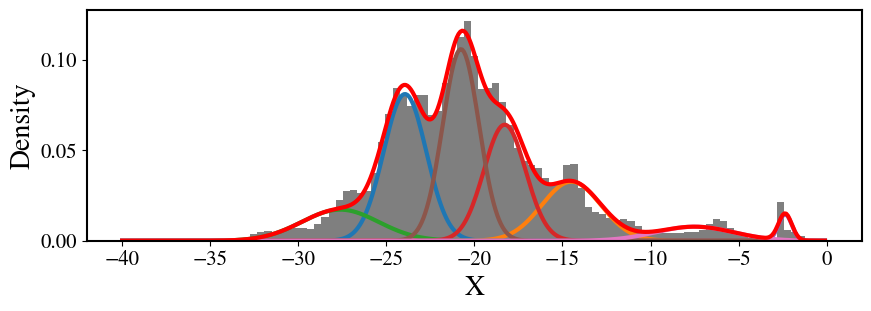

In [ ]:
# import libraries (some are for cosmetics)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


# create the data as in @Meng's answer
x = data['X1'].values
x = x.reshape(-1, 1)

# # first of all, let's confirm the optimal number of components
# bics = []
# min_bic = 0
# counter=1
# for i in range (10): # test the AIC/BIC metric between 1 and 10 components
#   gmm = GMM(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
#   labels = gmm.fit(x).predict(x)
#   bic = gmm.bic(x)
#   bics.append(bic)
#   if bic < min_bic or min_bic == 0:
#     min_bic = bic
#     opt_bic = counter
#   counter = counter + 1


# plot the evolution of BIC/AIC with the number of components
fig, ax = plt.subplots(1,1, figsize=(10, 3))
# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = 7

# create GMM model object
gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(x).means_  
covs  = gmm.fit(x).covariances_
weights = gmm.fit(x).weights_

# create necessary things to plot
x_axis = np.arange(-40, 0, 0.1)

full_pdf = 0

for i in range(n_optimal):
  y_axis = norm.pdf(x_axis, float(mean[i][0]), np.sqrt(float(covs[i][0][0])))*weights[i]
  ax.plot(x_axis, y_axis, lw=3, label='Component '+str(i+1))

  full_pdf = full_pdf + y_axis

#y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
#y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

# Plot 2
plt.hist(x, density=True, color='black', bins=np.linspace(-40, 0, 100), alpha=0.5)
plt.plot(x_axis, full_pdf, lw=3, c='red', label='Full PDF')

#plt.ylim(0.0, 2.0)
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

